# Fearon & Laitin Replication

Today, we're going to see if we can do a better job than Fearon & Laitin do in predicting the onset of civil wars. You may use any method you like, but I will get you started using their method (logistic regression) and also random forests.

To evaluate how well we do, we will use out-of-sample testing. I will help you divide the data into 3 sets: Training, Validation, and Testing. You should fit a model on the training data _only_ and evaluate how well it performs out-of-sample on the _validation_ data. Only once you have selected a _final_ model should you evaluate it's performance on the _test_ set. Once you've "peeked" at the test set, you should no longer continue to alter your model

In [1]:
import pandas as pd
import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("FearonLaitin.csv")

data.head()

,Unnamed: 0,ccode,country,cname,cmark,year,wars,war,warl,onset,...,empolity2l,sdwars,sdonset,colwars,colonset,cowwars,cowonset,cowwarl,sdwarl,colwarl
0,1,2,USA,USA,1,1945,0,0,0,0,...,7.68712,0,0,NaN,NaN,0.0,0.0,0.0,0,NaN
1,2,2,USA,USA,0,1946,0,0,0,0,...,10.00000,0,0,NaN,NaN,0.0,0.0,0.0,0,NaN
2,3,2,USA,USA,0,1947,0,0,0,0,...,10.00000,0,0,NaN,NaN,0.0,0.0,0.0,0,NaN
3,4,2,USA,USA,0,1948,0,0,0,0,...,10.00000,0,0,NaN,NaN,0.0,0.0,0.0,0,NaN
4,5,2,USA,USA,0,1949,0,0,0,0,...,10.00000,0,0,NaN,NaN,0.0,0.0,0.0,0,NaN


## Problem 1

Scikit learn likes to fit models to data in the form of two numpy arrays or pandas matrices. The first one, `X`, is a matrix of all your predictor variables (also known as independent variables). The second one, `y`, is the column vector of your dependent variables. If `X` is $(n \times k)$ dimensions, `y` is $(n \times 1)$. 

In [3]:
# First, I subset the data to just thos variables we need.
# Then I drop all rows with NA values.
all_variables = ["onset","warl","gdpenl","lpop","lmtnest","ncontig","Oil","nwstate","instab","polity2l","ethfrac","relfrac"]
data = data[all_variables].dropna()
data = data[data.onset != 4]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6191 entries, 0 to 6608
Data columns (total 12 columns):
onset       6191 non-null int64
warl        6191 non-null int64
gdpenl      6191 non-null float64
lpop        6191 non-null float64
lmtnest     6191 non-null float64
ncontig     6191 non-null int64
Oil         6191 non-null int64
nwstate     6191 non-null int64
instab      6191 non-null float64
polity2l    6191 non-null float64
ethfrac     6191 non-null float64
relfrac     6191 non-null float64
dtypes: float64(7), int64(5)
memory usage: 628.8 KB


Make two new dataframes. One called `X_matrix` with only the `x_variables` and one called `Y_matrix` with only the `y_variables`. 

In [4]:
x_variables = ["warl","gdpenl","lpop","lmtnest","ncontig","Oil","nwstate","instab","polity2l","ethfrac","relfrac"]
y_variables = "onset"
X_matrix = pd.DataFrame(data, columns=x_variables)
Y_matrix = pd.DataFrame(data, columns=[y_variables])
print("***********X_matrix***********")
print(X_matrix.info())
print("***********Y_matrix***********")
print(Y_matrix.info())

***********X_matrix***********
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6191 entries, 0 to 6608
Data columns (total 11 columns):
warl        6191 non-null int64
gdpenl      6191 non-null float64
lpop        6191 non-null float64
lmtnest     6191 non-null float64
ncontig     6191 non-null int64
Oil         6191 non-null int64
nwstate     6191 non-null int64
instab      6191 non-null float64
polity2l    6191 non-null float64
ethfrac     6191 non-null float64
relfrac     6191 non-null float64
dtypes: float64(7), int64(4)
memory usage: 580.4 KB
None
***********Y_matrix***********
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6191 entries, 0 to 6608
Data columns (total 1 columns):
onset    6191 non-null int64
dtypes: int64(1)
memory usage: 96.7 KB
None


## Problem 2

Use scikit learn's `model_selection.train_test_split` function to create a training set (called `train_X` and `train_Y`) and a hold-out set (called `holdout_X` and `holdout_Y`). You can find the documentation for this function here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Both the test set and the training set should be one half of the overall data. Set the random state for your split as `1234`. 

In [5]:
from sklearn.model_selection import train_test_split
train_X, holdout_X, train_Y, holdout_Y = train_test_split(X_matrix, np.array(Y_matrix.iloc[:,0]), test_size=0.50, random_state=1234)

## Problem 3

Now, let's split the holdout data in half to produce `test_X`, `test_Y`, `valid_X`, and `valid_Y`. Use the same random state as above.

In [6]:
test_X, valid_X, test_Y, valid_Y = train_test_split(holdout_X, holdout_Y, test_size=0.50, random_state=1234)

## Problem 4

Let's see if we can (relatively closely) replicate the model from Fearon & Laitin. They used logistic regression. Let's start by using _all_ of our data (training, test, and validation) combined to replicate their exact Model 1 from Table 1 (p. 84). 

Use sckit learn's `LogisticRegression` function with the following parameters:

* `penalty = "none"`
* `random_state=0`
* `max_iter=1000`
* `class_weight="balanced"`

Name your model `logit_all`. You can then use the `.fit(X_matrix, Y_matrix)` method to estimate the model.

Once you have an estimated model, use `print(logit_all.coef_)` to print the estimated coefficients. They should closely (but not exactly) match the results in model 1. 

In [7]:
from sklearn.linear_model import LogisticRegression
logit_all = LogisticRegression(penalty="none",random_state=0,max_iter=1000,class_weight="balanced", solver="newton-cg").fit(X_matrix, np.array(Y_matrix.iloc[:,0]))
print(logit_all.coef_)

[[-0.79053105 -0.33159313  0.227191    0.24723309  0.11802521  0.75136804
   1.57614109  0.60841823  0.01840325  0.35136008  0.22816365]]


## Problem 5

Let's see how well the model predicts civil war onset in-sample. Remember, we haven't held any data out for model evaluation. We trained on the same data that we're evaluating with. 

Start by making a new variable called `logit_all_pred` that represents your class predictions for each example in `X_matrix`. You can use the `logit_all.predict(...)` method.

In [8]:
logit_all_pred = logit_all.predict(X_matrix)

Now, use scikit learn's `classification_report()` function to evaluate how well the model predicts civil war onset. Use the `print()` function to make sure the report prints out nicely.

In [9]:
#print(classification_report(logit_all_pred,np.array(Y_matrix.iloc[:,0])))
print(classification_report(logit_all_pred,Y_matrix))

              precision    recall  f1-score   support

           0       0.66      0.99      0.79      4053
           1       0.67      0.03      0.06      2138

    accuracy                           0.66      6191
   macro avg       0.67      0.51      0.43      6191
weighted avg       0.66      0.66      0.54      6191



Finally, follow along with the example given in block 16 of https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html to create a confusion matrix to visually represent predictive performance of the model.

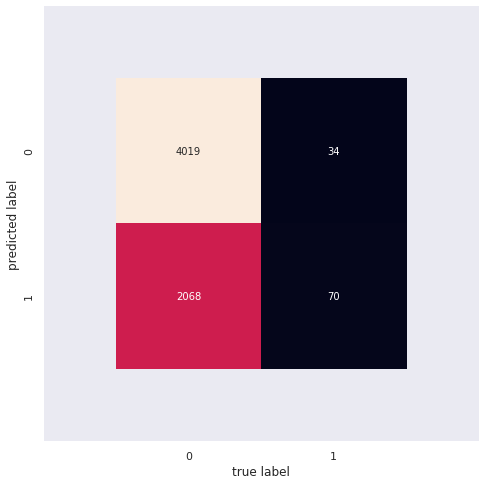

In [10]:
from sklearn.metrics import confusion_matrix
#y = Y_matrix.iloc[:,0]
y = Y_matrix
mat = confusion_matrix(y, logit_all_pred)
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(mat.T, square=True, annot=True,fmt='d',  cbar=False, ax=ax)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.xlim(-0.5, len(np.unique(y))+0.5)
plt.ylim(len(np.unique(y))+0.5, -0.5)
plt.show()

## Problem 6

Let's repeat the above process the right way. Make a new logit model called `logit_model` using just the `train_X` and `train_Y`. Keep all other hyperparameters the same.

In [11]:
logit_model = LogisticRegression(penalty="none",random_state=0,max_iter=1000,class_weight="balanced", solver="newton-cg").fit(train_X, np.array(train_Y))

Create predictions for your new model, called `logit_pred`, using the `valid_X` data.

In [12]:
logit_pred = logit_model.predict(valid_X)

Print the classification report for `logit_pred` compared to the true values, `valid_Y`. 

In [13]:
print(classification_report(logit_pred,valid_Y))

              precision    recall  f1-score   support

           0       0.67      0.99      0.80      1032
           1       0.65      0.03      0.06       516

    accuracy                           0.67      1548
   macro avg       0.66      0.51      0.43      1548
weighted avg       0.67      0.67      0.55      1548



## Problem 7

As you can see, the Fearon & Laitin model doesn't do a particularly great job predicting civil war onsets. If we've done everything right, the classification accuracy should be around 67%. That's not horrible, but the false positive rate is very high.

Let's now try to model this using a random forest classifier. We will use the `RandomForestClassifier` function from scikit learn. Make a new object called `rf_model` with the following hyperparemeters:

* `n_estimators=100`
* `max_depth=3`
* `random_state=1234`

Then, fit your model to `train_X` and `train_Y`. 

In [14]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=3,random_state=1234)
rf_model.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

## Problem 8

We can check out which features contribute most to our predictive power. Use the `.feature_importances_` attribute to print the weights assigned to each feature. These should sum to 1, meaning they are proportions. If you want, you `zip(...)` them with `x_variables` so it is easy to see which variable is associated with which feature importance.

In [15]:
print("Sum of feature_importances_:", sum(rf_model.feature_importances_), "\n")
for val in zip(x_variables, rf_model.feature_importances_):
    print(val)

Sum of feature_importances_: 0.9999999999999999 

('warl', 0.0322428459598)
('gdpenl', 0.20936159847803074)
('lpop', 0.2828006470547031)
('lmtnest', 0.10117348113401987)
('ncontig', 0.021010034279262197)
('Oil', 0.02205616333272554)
('nwstate', 0.0587352294680228)
('instab', 0.04750285174276676)
('polity2l', 0.07423580985367105)
('ethfrac', 0.06251458764483225)
('relfrac', 0.08836675105216567)


## Problem 9

Use the `predict` method again to create `rf_pred`, the predictions for the validation set from your random forest model.

In [16]:
rf_pred = rf_model.predict(valid_X)

## Problem 10

Print both the classification report and the confusion matrix for your random forest model using the validation data.

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1548
           1       0.00      0.00      0.00         0

    accuracy                           0.99      1548
   macro avg       0.50      0.49      0.50      1548
weighted avg       1.00      0.99      0.99      1548

(1548, 11)


/home/youngjb/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


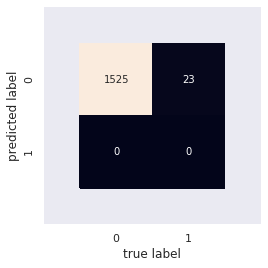

Balanced Accuracy Score: 0.5


In [17]:
print(classification_report(rf_pred,valid_Y))
print(valid_X.shape)
len(valid_Y[valid_Y == 1])
mat = confusion_matrix(valid_Y, rf_pred)
sns.heatmap(mat.T, square=True, annot=True,fmt='d',  cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.xlim(-0.5, len(np.unique(valid_Y))+0.5)
plt.ylim(len(np.unique(valid_Y))+0.5, -0.5)
plt.show()
#  Take note of the following waring message:  
# "UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples."
# It appears this warning was generated because zero out of 23 1's were predicted correctly:
# https://stackoverflow.com/questions/34757653/why-does-scikitlearn-says-f1-score-is-ill-defined-with-fn-bigger-than-0

from sklearn.metrics import balanced_accuracy_score
accuracy = balanced_accuracy_score(valid_Y, rf_pred)
print("Balanced Accuracy Score:", accuracy)

In [18]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## Problem 11

Adjust the model as you feel necessary and evaluate its performance on the validation data. You can choose any evaluation metric you like. Once you are satisfied with your model's performance on the validation data, evaluate its performance on the test data. Report the performance of your model on the test data. If you'd like, you can use scikit learn's `GridSearchCV` or related functions to help you pick a "best" model. This is a hard problem. If you can't beat the above model, don't stress. It is really really really hard to predict civil war onsets.

In [19]:
from sklearn.model_selection import GridSearchCV

# Instantiate baskic RandomForestClassifier
rf_model_fnl = RandomForestClassifier(random_state=1234)

# Create set of parameters for tuning
model_params = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6],
    'max_depth':[2,3,4,5]
}

# Tune parameters
clf = GridSearchCV(rf_model, model_params, cv=5, n_jobs = 4, scoring = 'balanced_accuracy')

# train the grid search meta-estimator to find the best model
model = clf.fit(train_X, train_Y)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

# Invoke classifier
y_pred = model.predict(test_X)

# Assess accuracy via balanced accuracy score
accuracy = balanced_accuracy_score(test_Y, y_pred)
print("Balance Accuracy Score with Test Data:", accuracy)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}
Balance Accuracy Score with Test Data: 0.5


## Problem 12

Pick a dataset of your choice (from your research or from Googling) and apply a random forest to it. Be prepared to describe the problem that you picked, your modeling choices, and the results of your model. Did it perform better or worse than you expected? Why? What could be done to improve it?

## Step 1:  Download [Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) from UCI Machine Learning Repository

In [20]:
tdf = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', sep = ',')
header = ["age", "sex", "cp", "trestbps", "chol", "fbs","restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
tdf.columns = header
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
age         302 non-null float64
sex         302 non-null float64
cp          302 non-null float64
trestbps    302 non-null float64
chol        302 non-null float64
fbs         302 non-null float64
restecg     302 non-null float64
thalach     302 non-null float64
exang       302 non-null float64
oldpeak     302 non-null float64
slope       302 non-null float64
ca          302 non-null object
thal        302 non-null object
num         302 non-null int64
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


## Step 2:  Trim, Modify & Scale Dataset

************missing ca values************
      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
165  52.0  1.0  3.0     138.0  223.0  0.0      0.0    169.0    0.0      0.0   
191  43.0  1.0  4.0     132.0  247.0  1.0      2.0    143.0    1.0      0.1   
286  58.0  1.0  2.0     125.0  220.0  0.0      0.0    144.0    0.0      0.4   
301  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope ca thal  num  
165    1.0  ?  3.0    0  
191    2.0  ?  7.0    1  
286    2.0  ?  7.0    0  
301    1.0  ?  3.0    0  

************missing thal values************
      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
86   53.0  0.0  3.0     128.0  216.0  0.0      2.0    115.0    0.0      0.0   
265  52.0  1.0  4.0     128.0  204.0  1.0      0.0    156.0    1.0      1.0   

     slope   ca thal  num  
86     1.0  0.0    ?    0  
265    2.0  0.0    ?    2  


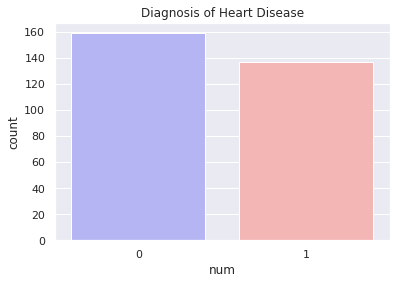

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 300
Data columns (total 13 columns):
age         296 non-null float64
sex         296 non-null float64
cp          296 non-null float64
trestbps    296 non-null float64
chol        296 non-null float64
fbs         296 non-null float64
restecg     296 non-null float64
thalach     296 non-null float64
exang       296 non-null float64
oldpeak     296 non-null float64
slope       296 non-null float64
ca          296 non-null float64
thal        296 non-null float64
dtypes: float64(13)
memory usage: 42.4 KB
None


In [21]:
from sklearn.preprocessing import StandardScaler

# Display rows of missing data
print("************missing ca values************")
print(tdf[(tdf["ca"] == "?")])
print()
print("************missing thal values************")
print(tdf[(tdf["thal"] == "?")])

# Remove rows with missing values for "ca" field
tdf = tdf.loc[lambda df: df["ca"] != "?", :]
# Remove rows with missing values for "ca" field
tdf = tdf.loc[lambda df: df["thal"] != "?", :]

# Set "num" field = 1 when value > 1
tdf.loc[tdf.num > 1, 'num'] = 1

# Change type of "ca" and "thal" fields to "float64"
tdf["ca"] = tdf["ca"].astype("float64")
tdf["thal"] = tdf["thal"].astype("float64")

# Remove diagnosis column (num)
heartData = tdf.iloc[:, :-1]

# Store diagnosis labels separately
heartLabels = tdf.iloc[:, 13]

sns.countplot(x="num", data=tdf, palette="bwr").set_title('Diagnosis of Heart Disease')
plt.show()

print(heartData.info())

# Scale data set
scaler_heart = StandardScaler()
heartData = scaler_heart.fit_transform(heartData)

## Step 3:  Partition Train & Test Data

In [22]:
train_heart_X, test_heart_X, train_heart_Y, test_heart_Y = train_test_split(heartData, heartLabels, test_size=0.50, random_state=1234)

## Step 4: Train Random Forest Classifier

In [23]:
rf_heart_model = RandomForestClassifier(n_estimators=1000, max_depth=3,random_state=1234)
rf_heart_model.fit(train_heart_X, train_heart_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

## Step 5: Invoke Random Forest Classifier

In [24]:
heart_disease_pred = rf_heart_model.predict(test_heart_X)

## Step 6: Assess Accuracy of  Random Forest Classifier

              precision    recall  f1-score   support

           0       0.86      0.83      0.84        86
           1       0.77      0.81      0.79        62

    accuracy                           0.82       148
   macro avg       0.81      0.82      0.81       148
weighted avg       0.82      0.82      0.82       148



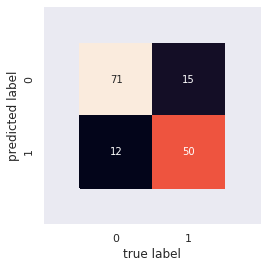

Fowlkes Mallows Score: 0.7037924234041132


In [25]:
print(classification_report(heart_disease_pred,test_heart_Y))


mat = confusion_matrix(test_heart_Y, heart_disease_pred)
sns.heatmap(mat.T, square=True, annot=True,fmt='d',  cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.xlim(-0.5, len(np.unique(test_heart_Y))+0.5)
plt.ylim(len(np.unique(test_heart_Y))+0.5, -0.5)
plt.show()
#  Take note of the following waring message:  
# "UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples."
# It appears this warning was generated because zero out of 23 1's were predicted correctly:
# https://stackoverflow.com/questions/34757653/why-does-scikitlearn-says-f1-score-is-ill-defined-with-fn-bigger-than-0

from sklearn.metrics.cluster import fowlkes_mallows_score
heart_disease_accuracy = fowlkes_mallows_score(test_heart_Y, heart_disease_pred)
print("Fowlkes Mallows Score:", heart_disease_accuracy)

## Did it perform better or worse than you expected? Why? 
The Random Forest algorithm (RFA) performed slightly worse than expected in classifying the heart disease data.  Using the same Fowlkes Mallows Score metric, I was able to obtain a score of 73% using the k-means clustering algorithm.  I was expecting to achieve a similar score using RFA.   

## What could be done to improve it?
I could probably obtain a higher score by tuning the model parameters of RFA using GridSearchCV.